In [1]:
import sys
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import math
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cm_data = [[1,1,1], #added
    [0.2081, 0.1663, 0.5292], [0.2116238095, 0.1897809524, 0.5776761905], 
 [0.212252381, 0.2137714286, 0.6269714286], [0.2081, 0.2386, 0.6770857143], 
 [0.1959047619, 0.2644571429, 0.7279], [0.1707285714, 0.2919380952, 
  0.779247619], [0.1252714286, 0.3242428571, 0.8302714286], 
 [0.0591333333, 0.3598333333, 0.8683333333], [0.0116952381, 0.3875095238, 
  0.8819571429], [0.0059571429, 0.4086142857, 0.8828428571], 
 [0.0165142857, 0.4266, 0.8786333333], [0.032852381, 0.4430428571, 
  0.8719571429], [0.0498142857, 0.4585714286, 0.8640571429], 
 [0.0629333333, 0.4736904762, 0.8554380952], [0.0722666667, 0.4886666667, 
  0.8467], [0.0779428571, 0.5039857143, 0.8383714286], 
 [0.079347619, 0.5200238095, 0.8311809524], [0.0749428571, 0.5375428571, 
  0.8262714286], [0.0640571429, 0.5569857143, 0.8239571429], 
 [0.0487714286, 0.5772238095, 0.8228285714], [0.0343428571, 0.5965809524, 
  0.819852381], [0.0265, 0.6137, 0.8135], [0.0238904762, 0.6286619048, 
  0.8037619048], [0.0230904762, 0.6417857143, 0.7912666667], 
 [0.0227714286, 0.6534857143, 0.7767571429], [0.0266619048, 0.6641952381, 
  0.7607190476], [0.0383714286, 0.6742714286, 0.743552381], 
 [0.0589714286, 0.6837571429, 0.7253857143], 
 [0.0843, 0.6928333333, 0.7061666667], [0.1132952381, 0.7015, 0.6858571429], 
 [0.1452714286, 0.7097571429, 0.6646285714], [0.1801333333, 0.7176571429, 
  0.6424333333], [0.2178285714, 0.7250428571, 0.6192619048], 
 [0.2586428571, 0.7317142857, 0.5954285714], [0.3021714286, 0.7376047619, 
  0.5711857143], [0.3481666667, 0.7424333333, 0.5472666667], 
 [0.3952571429, 0.7459, 0.5244428571], [0.4420095238, 0.7480809524, 
  0.5033142857], [0.4871238095, 0.7490619048, 0.4839761905], 
 [0.5300285714, 0.7491142857, 0.4661142857], [0.5708571429, 0.7485190476, 
  0.4493904762], [0.609852381, 0.7473142857, 0.4336857143], 
 [0.6473, 0.7456, 0.4188], [0.6834190476, 0.7434761905, 0.4044333333], 
 [0.7184095238, 0.7411333333, 0.3904761905], 
 [0.7524857143, 0.7384, 0.3768142857], [0.7858428571, 0.7355666667, 
  0.3632714286], [0.8185047619, 0.7327333333, 0.3497904762], 
 [0.8506571429, 0.7299, 0.3360285714], [0.8824333333, 0.7274333333, 0.3217], 
 [0.9139333333, 0.7257857143, 0.3062761905], [0.9449571429, 0.7261142857, 
  0.2886428571], [0.9738952381, 0.7313952381, 0.266647619], 
 [0.9937714286, 0.7454571429, 0.240347619], [0.9990428571, 0.7653142857, 
  0.2164142857], [0.9955333333, 0.7860571429, 0.196652381], 
 [0.988, 0.8066, 0.1793666667], [0.9788571429, 0.8271428571, 0.1633142857], 
 [0.9697, 0.8481380952, 0.147452381], [0.9625857143, 0.8705142857, 0.1309], 
 [0.9588714286, 0.8949, 0.1132428571], [0.9598238095, 0.9218333333, 
  0.0948380952], [0.9661, 0.9514428571, 0.0755333333], 
 [0.9763, 0.9831, 0.0538]]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)

In [2]:
# !git clone https://gitlab.ifremer.fr/lops-wave/scatterplot.git

Cloning into 'scatterplot'...
remote: Enumerating objects: 9, done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 9
Unpacking objects: 100% (9/9), done.


In [4]:
!pip install pytorch-lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

     |████████████████████████████████| 925 kB 6.6 MB/s 
     |████████████████████████████████| 829 kB 65.6 MB/s 
     |████████████████████████████████| 125 kB 68.5 MB/s 
     |████████████████████████████████| 636 kB 67.9 MB/s 
     |████████████████████████████████| 282 kB 88.4 MB/s 
     |████████████████████████████████| 1.3 MB 77.5 MB/s 
     |████████████████████████████████| 160 kB 90.6 MB/s 
     |████████████████████████████████| 271 kB 74.6 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=13263b4c5205618841be732fb61fb373ebf3c447c9cac734355378e19c8c3ef8
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-0

# Proposed model

In [5]:
class Net_spectral(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 64, 3)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.conv3 = nn.Conv2d(128, 256, 3)
        # self.conv4 = nn.Conv2d(256, 512, 3)

        self.maxpooling2d = nn.MaxPool2d(2, 2)
        self.globalmaxpooling2d = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p=0.5)

        self.fc512_n1 = nn.Linear(256, 256)
        self.fc512_n2 = nn.Linear(256, 256)

    def forward(self, x):
        x = self.maxpooling2d(F.relu(self.conv1(x)))
        x = self.maxpooling2d(F.relu(self.conv2(x)))
        x = self.maxpooling2d(F.relu(self.conv3(x)))
        # x = self.maxpooling2d(F.relu(self.conv4(x)))
        x= self.globalmaxpooling2d(x)
        x = F.relu(self.fc512_n1(torch.squeeze(x)))

        x = F.relu(self.fc512_n2(x))
        x = self.dropout(x)
        return x

class MLP_output(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.dropout_n1 = nn.Dropout(p=0.5)
        self.dropout_n2 = nn.Dropout(p=0.5)
        self.dropout_n3 = nn.Dropout(p=0.5)


        self.fc256 = nn.Linear(256, 256)

        # self.fc1024_512 = nn.Linear(1024, 512)
        self.fc512_256 = nn.Linear(512, 256)
        self.fc256_128 = nn.Linear(256, 128)
        self.fc128_2 = nn.Linear(128,2)

    def forward(self, x):


        # x = F.relu(self.fc1024_512(x))
        # x = self.dropout_n1(x)
        # x = F.relu(self.fc512_256(x))
        # x = self.dropout_n2(x)
        x = F.relu(self.fc256_128(x))
        x = self.dropout_n3(x)

        output = F.softplus(self.fc128_2(x))

        return output



class Net_cwave(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.dropout = nn.Dropout(p=0.5)
        self.softmax = nn.Softmax(dim = 1)


        self.fc10_64 = nn.Linear(10, 64)
        self.fc64_128 = nn.Linear(64, 128)
        self.fc128_256 = nn.Linear(128, 256)
        self.fc256_512 = nn.Linear(256, 512)
        self.fc512_1024 = nn.Linear(512, 1024)
        self.fc1024_2048 = nn.Linear(1024,2048)

    def forward(self, x):
        x = F.relu(self.fc10_64(x[:,22:]))
        x = F.relu(self.fc64_128(x))
        x = F.relu(self.fc128_256(x))
        x = F.relu(self.fc256_512(x))
        x = F.relu(self.fc512_1024(x))
        x = F.relu(self.fc1024_2048(x))
        x = x.view(-1,8,256)

        x = self.softmax(x)
        x = self.dropout(x)
        return x

# combination of two NN
class Net_comb(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.maxpooling2d = nn.MaxPool2d(2, 2)
        self.globalmaxpooling2d = nn.AdaptiveMaxPool2d(1)

        self.dropout_n1 = nn.Dropout(p=0.5)
        self.dropout_n2 = nn.Dropout(p=0.5)

        self.fc256 = nn.Linear(256, 256)
        self.fc256_128 = nn.Linear(256, 128)
        self.fc128_1 = nn.Linear(128, 1)

        self.net_cwave = Net_cwave()

        self.net_spectral_n1 = Net_spectral()
        self.net_spectral_n2 = Net_spectral()
        self.net_spectral_n3 = Net_spectral()
        self.net_spectral_n4 = Net_spectral()
        self.net_spectral_n5 = Net_spectral()
        self.net_spectral_n6 = Net_spectral()
        self.net_spectral_n7 = Net_spectral()
        self.net_spectral_n8 = Net_spectral()

        self.mlp_out = MLP_output()
        # self.mlp_out_2 = MLP_output()

    def forward(self, x1,x2):

        cnn_output_n1 = self.net_spectral_n1(x1)
        cnn_output_n2 = self.net_spectral_n2(x1)
        cnn_output_n3 = self.net_spectral_n3(x1)
        cnn_output_n4 = self.net_spectral_n4(x1)
        cnn_output_n5 = self.net_spectral_n5(x1)
        cnn_output_n6 = self.net_spectral_n6(x1)
        cnn_output_n7 = self.net_spectral_n7(x1)
        cnn_output_n8 = self.net_spectral_n8(x1)

        cnn_output_matrix = torch.cat([cnn_output_n1,cnn_output_n2,cnn_output_n3,cnn_output_n4,cnn_output_n5,cnn_output_n6,cnn_output_n7,cnn_output_n8],dim=1)
        cnn_output_matrix = cnn_output_matrix.view(-1,8,256)
        # print(self.net_cwave(x2).size())
        # print(cnn_output_matrix.size())
        x = cnn_output_matrix*self.net_cwave(x2)

        x = torch.sum(x,1)

        output = self.mlp_out(x)

        return output


    def training_step(self, batch, batch_idx):
        x, y_true = batch
        x1,x2 = x

        x1 = torch.cat([x1, torch.cat([torch.unsqueeze(x1[:,0,:,:],1),torch.unsqueeze(torch.zeros_like(x1[:,1,:,:]),1)],1)],0)
        x2 = torch.cat([x2,x2],0)

        y_pre = self.forward(x1,x2)


        loss_f = nn.GaussianNLLLoss()
        loss = loss_f(y_pre[:,0], torch.cat([torch.squeeze(y_true).float(),torch.squeeze(y_true).float()],0) ,y_pre[:,1])
        self.log('train_loss', loss)

        return loss



    def validation_step(self, batch, batch_idx):

        x, y_true = batch
        x1,x2 = x
        
        y_pre = self.forward(x1,x2)

        loss = F.mse_loss(y_pre[:,0], torch.squeeze(y_true))
        self.log('val_loss', loss)
    
        return loss

    def test_step(self, batch, batch_idx):

        x, y_true = batch
        x1,x2 = x
        
        y_pre = self.forward(x1,x2)
        loss = F.mse_loss(y_pre[:,0], torch.squeeze(y_true))
        self.log('test_loss', loss)
        
        return loss

    def configure_optimizers(self):

        optimizer = torch.optim.Adam(self.parameters(), lr=0.0003)
        scheduler = ReduceLROnPlateau(optimizer, factor=0.8, patience= 1)

        return { 'optimizer': optimizer, 'lr_scheduler': { 'scheduler': scheduler, 'monitor': 'val_loss', } }

# Average six prediction of model proposed which are trained with fixed epochs (Data augmentation and attention network)

In [10]:
class Net_comb_6(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.m1 = Net_comb.load_from_checkpoint('/content/drive/MyDrive/sar_img/model/model_nllloss_k=8_256_batch_256_aug_fix_30epoch_p5_lr08_v1/lightning_logs/version_6/checkpoints/epoch=31-step=71199.ckpt')
        self.m2 = Net_comb.load_from_checkpoint('/content/drive/MyDrive/sar_img/model/model_nllloss_k=8_256_batch_256_aug_fix_30epoch_p5_lr08_v1/lightning_logs/version_8/checkpoints/epoch=31-step=71199.ckpt')
        self.m3 = Net_comb.load_from_checkpoint('/content/drive/MyDrive/sar_img/model/model_nllloss_k=8_256_batch_256_aug_fix_30epoch_p5_lr08_v2/lightning_logs/version_0/checkpoints/epoch=31-step=71199.ckpt')
        self.m4 = Net_comb.load_from_checkpoint('/content/drive/MyDrive/sar_img/model/model_nllloss_k=8_256_batch_256_aug_fix_30epoch_p5_lr08_v2/lightning_logs/version_2/checkpoints/epoch=31-step=71199.ckpt')
        self.m5 = Net_comb.load_from_checkpoint('/content/drive/MyDrive/sar_img/model/model_nllloss_k=8_256_batch_256_aug_fix_30epoch_p5_lr08_v2/lightning_logs/version_3/checkpoints/epoch=31-step=71199.ckpt')
        self.m6 = Net_comb.load_from_checkpoint('/content/drive/MyDrive/sar_img/model/model_nllloss_k=8_256_batch_256_aug_fix_30epoch_p5_lr08_v2/lightning_logs/version_7/checkpoints/epoch=31-step=71199.ckpt')

    def forward(self, x1,x2):

        out = torch.cat([torch.unsqueeze(self.m1(x1,x2),2),torch.unsqueeze(self.m2(x1,x2),2),torch.unsqueeze(self.m3(x1,x2),2),torch.unsqueeze(self.m4(x1,x2),2),torch.unsqueeze(self.m5(x1,x2),2),torch.unsqueeze(self.m6(x1,x2),2)],2)
        out = torch.mean(out,2)


        return out

    def training_step(self, batch, batch_idx):
        x, y_true = batch
        x1,x2 = x

        x1 = torch.cat([x1, torch.cat([torch.unsqueeze(x1[:,0,:,:],1),torch.unsqueeze(torch.zeros_like(x1[:,1,:,:]),1)],1)],0)
        x2 = torch.cat([x2,x2],0)

        y_pre = self.forward(x1,x2)


        loss_f = nn.GaussianNLLLoss()
        loss = loss_f(y_pre[:,0], torch.cat([torch.squeeze(y_true).float(),torch.squeeze(y_true).float()],0) ,y_pre[:,1])
        self.log('train_loss', loss)

        return loss



    def validation_step(self, batch, batch_idx):

        x, y_true = batch
        x1,x2 = x
        
        y_pre = self.forward(x1,x2)

        loss = F.mse_loss(y_pre[:,0], torch.squeeze(y_true))
        self.log('val_loss', loss)
    
        return loss

    def test_step(self, batch, batch_idx):

        x, y_true = batch
        x1,x2 = x
        
        y_pre = self.forward(x1,x2)
        loss = torch.mean(torch.square(y_pre[:,0]-torch.squeeze(y_true)))
        self.log('test_loss', loss)
        
        return loss

    def predict_step(self, batch, batch_idx):
        x, y_true = batch
        x1,x2 = x

        y_pre = self.forward(x1,x2)
        return y_pre

    def configure_optimizers(self):
        
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0003)
        scheduler = ReduceLROnPlateau(optimizer, factor=0.8, patience= 4)

        return { 'optimizer': optimizer, 'lr_scheduler': { 'scheduler': scheduler, 'monitor': 'val_loss', } }
    

# Load data

In [7]:
class Dataset_torch(Dataset):

    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data['y'])    

    def __getitem__(self, idx):
        
        inputs = [self.data['x1'][idx],self.data['x2'][idx].float()]
        return inputs, self.data['y'][idx]
        

In [8]:
data_18 = torch.load('/content/drive/MyDrive/sar_img/dataset/tensors_2018.pt')
dataset_2018 = Dataset_torch(data_18)
data_loader_2018 = torch.utils.data.DataLoader(dataset=dataset_2018, batch_size=1024,num_workers=2)

# Test

In [11]:
model_6 = Net_comb_6()
trainer = pl.Trainer(gpus=1)
trainer.test(model=model_6,test_dataloaders = data_loader_2018)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.085863396525383}
--------------------------------------------------------------------------------


[{'test_loss': 0.085863396525383}]

# Prediction

In [ ]:
predict_2018_test_k8 = trainer.predict(model=model_6,dataloaders = data_loader_2018)

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, predict dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Predicting: 0it [00:00, ?it/s]

In [ ]:
predict_2018_test_k8 = torch.cat(predict_2018_test_k8)
predict_2018_test_k8.shape

torch.Size([185151, 2])

# Save and load prediction

In [ ]:
torch.save(predict_2018_test_k8, '/content/drive/MyDrive/sar_img/dataset/predict_2018_test_k8_avg6_aug_fix_new.pt')

In [18]:
predict_2018_test_k8_aug = torch.load('/content/drive/MyDrive/sar_img/dataset/predict_2018_test_k8_avg6_aug_fix_new.pt')

# Plot

(185151,)
(185151,)


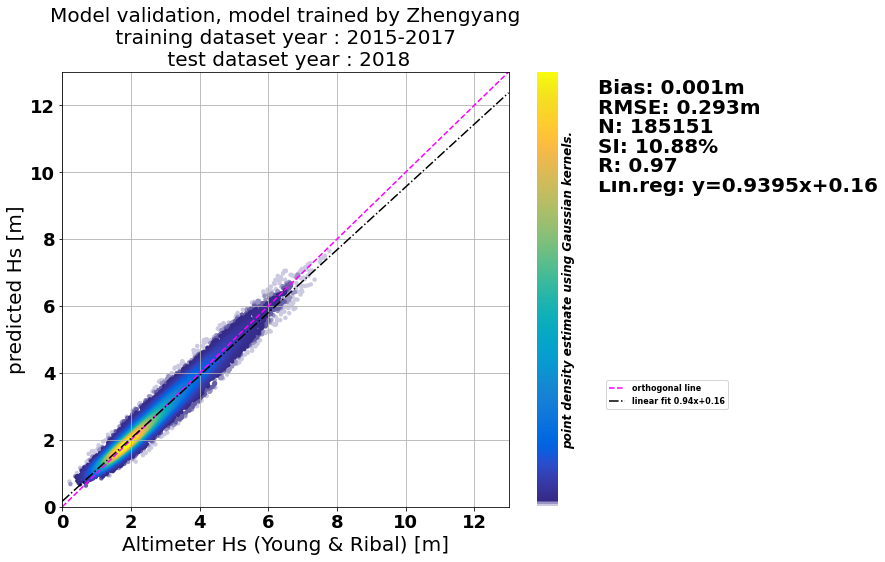

In [19]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)
sys.path.append('/home1/datahome/agrouaze/git/mpc/qualitycheck/')
import utilscalval
from importlib import reload
reload(utilscalval)
y = predict_2018_test_k8_aug[:,0]
y = y.cpu().numpy()
x = data_18['y'][:,0].numpy()
#y = predict_2018_original_keras[:,0].squeeze()
print(x.shape)
print(y.shape)
# tit = 'keras model validation \nQuach et al. 2020 methodology\n model trained by Zhengyang LAN \n training dataset year : 2018'
# tit = 'keras model validation \nQuach et al. 2020 methodology\n model trained by Hawaiian team \n training dataset year : 2018'
tit = 'Model validation, model trained by Zhengyang\n training dataset year : 2015-2017 \n test dataset year : 2018'
xlabel='Altimeter Hs (Young & Ribal) [m]'
ylabel='predicted Hs [m]'
utilscalval.plot_scat_dens(x,y,xlabel=xlabel,ylabel=ylabel,title=tit,gaussian_fit=False,mean_curve=False,
                           ortho=True,unit='m',xlimits=(0,13),ylimits=(0,13),print_stat=True,linear_fit=True,
                           fontsize=20,logdensity=False,cmap=parula_map,add_points=False)
plt.show()